## Subway EDA 1

### library import

In [1]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### 데이터 불러오기

In [2]:
data_path: str = "../../data"
etc_path: str = "../../data/etc"
subway_info: pd.DataFrame = pd.read_csv(os.path.join(data_path,"subwayinfo.csv"))
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path,"train.csv"))
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path,"test.csv"))
train_df.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0


In [3]:
# path 설정
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))
print(sys.path[-1])

d:\base\boostcamp\apart\level2-competitiveds-recsys-06


In [4]:
# _type 컬럼 생성
train_df["_type"] = "train"
test_df["_type"] = "test"

# concat_df 생성
concat_df = pd.concat([train_df,test_df],axis=0)

In [5]:
from src.pre_procecss.feature_add import FeatureAddition

# pre_procecss에서 클래스 가져와서 apt_idx, area, area_price, aream2_price 컬럼 생성
df = FeatureAddition(concat_df).get_data()
df.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,_type,apt_idx,area,area_price,area_m2_price
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,train,0,25.8,658.914729,200.004471
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,train,0,25.8,891.472868,270.594284
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,train,0,25.8,891.472868,270.594284
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0,train,1,18.0,277.777778,84.260195
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0,train,2,18.1,99.447514,30.095302


## subway_info에 feature 추가

### subway 번호 매긴 후 정렬

In [6]:
# subway_info에 index로 subway_code 부여
subway_info['subway_idx'] = subway_info.index

In [7]:
subway_info.head()

,latitude,longitude,subway_idx
0,37.759380,127.042292,0
1,37.541021,126.971300,1
2,37.529849,126.964561,2
3,37.514219,126.942454,3
4,37.513342,126.926382,4


In [8]:
# 위도, 경도순으로 정렬
subway_sorted = subway_info.sort_values(by=['latitude', 'longitude'])
subway_sorted.head()

,latitude,longitude,subway_idx
21,36.769502,126.951108,21
19,36.777629,127.052991,19
20,36.780483,127.003249,20
18,36.792053,127.104361,18
17,36.793759,127.121400,17


### 환승역 컬럼 생성

In [9]:
# 환승역 'Interchange_station' 컬럼을 만들어서 latitude와 longitude가 같은 행의 개수를 컬럼에 추가
subway_sorted['Interchange_station'] = subway_sorted.groupby(['latitude', 'longitude'])['latitude'].transform('count')
subway_sorted.head()

,latitude,longitude,subway_idx,Interchange_station
21,36.769502,126.951108,21,1
19,36.777629,127.052991,19,1
20,36.780483,127.003249,20,1
18,36.792053,127.104361,18,1
17,36.793759,127.121400,17,1


In [10]:
# latitude와 longitude가 같은 행끼리 subway_code가 낮은 것 하나만 남기고 나머지는 제거
subway_sorted = subway_sorted.loc[subway_sorted.groupby(['latitude', 'longitude'])['subway_idx'].idxmin()]
subway_sorted.head()

,latitude,longitude,subway_idx,Interchange_station
21,36.769502,126.951108,21,1
19,36.777629,127.052991,19,1
20,36.780483,127.003249,20,1
18,36.792053,127.104361,18,1
17,36.793759,127.121400,17,1


In [11]:
# subway_sorted의 행 개수를 출력
num_rows = subway_sorted.shape[0]
print(f"subway_sorted 행 개수: {num_rows}")

subway_sorted 행 개수: 583


In [13]:
# # csv 저장
# subway_sorted.to_csv(os.path.join(etc_path, "subway_sorted_interchange_deduplication.csv"), index=False)

## 가장 가까운 subway 피처 train과 test에 생성

In [12]:
# apt_idx가 같은 것들 중에서 _type이 train인 것이 우선이고, contract_year_month가 빠른 것이 그 다음 우선순위로 하나씩만 추출
temp_df = df.sort_values(by=['apt_idx', '_type', 'contract_year_month']).drop_duplicates(subset='apt_idx', keep='first')
temp_df.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,_type,apt_idx,area,area_price,area_m2_price
77296,77296,84.9981,202401,5,0,19,2019,37.054314,127.045216,5,NaN,test,0,25.8,NaN,NaN
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0,train,1,18.0,277.777778,84.260195
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0,train,2,18.1,99.447514,30.095302
67649,67649,84.9342,202401,6,2,14,2016,36.965423,127.048779,8,NaN,test,3,25.7,NaN,NaN
2,2,39.2700,202404,29,0,5,1990,36.957089,127.047449,34,NaN,test,4,11.9,NaN,NaN


In [13]:
temp_df.shape[0]

18676

In [17]:
# # csv 저장
# temp_df.to_csv(os.path.join(etc_path, "apt_idx_representative.csv"), index=False)

## 지하철역 관련 feature 생성

### 준비과정

In [14]:
from sklearn.neighbors import BallTree

# 지구의 평균 반경 (킬로미터 단위, Haversine 공식에 필요)
EARTH_RADIUS_KM = 6371.0

# 아파트의 위도와 경도를 라디안으로 변환
temp_df_rad = np.radians(temp_df[['latitude', 'longitude']].values)

# 지하철 역의 위도와 경도를 라디안으로 변환
subway_sorted_rad = np.radians(subway_sorted[['latitude', 'longitude']].values)

# BallTree 생성 (Haversine 거리 메트릭 사용)
tree = BallTree(subway_sorted_rad, metric='haversine')

### 가장 가까운 지하철역 찾기

In [15]:
# 각 아파트에 대해 가장 가까운 지하철역과 그 거리 찾기
distances, indices = tree.query(temp_df_rad, k=1)

# 거리 (라디안)를 미터 단위로 변환
temp_df['nearest_subway_distance'] = distances.flatten() * EARTH_RADIUS_KM * 1000  # meters

# 가장 가까운 지하철역의 subway_idx 추출
temp_df['nearest_subway_idx'] = subway_sorted['subway_idx'].iloc[indices.flatten()].values

### 반경 1km내의 지하철역 찾기

In [16]:
# 반경 1km을 라디안으로 변환
radius = 1 / EARTH_RADIUS_KM

# 각 아파트에 대해 반경 1km 내의 지하철역 인덱스 찾기
indices_within_1km = tree.query_radius(temp_df_rad, r=radius)

# 반경 1km 내의 지하철역 개수
temp_df['num_subway_within_1km'] = [len(ind) for ind in indices_within_1km]

# 반경 1km 내의 지하철역 subway_idx 리스트
temp_df['list_subway_idx_within_1km'] = [subway_sorted['subway_idx'].iloc[ind].tolist() for ind in indices_within_1km]

### 반경 1km 내에 환승역(Interchange_station이 2 이상) 존재 여부

In [17]:
'''
반경 1km 내에 Interchange_station이 2 이상인 지하철역 존재 여부를 기반으로 'has_interchange_within_1km' 열 생성
조건:
0: 지하철역 없음
1: 지하철역 1개 이상, 환승역 없음
2: 지하철역 1개 이상, 환승역 포함
'''

temp_df['category_interchange_within_1km'] = [
    0 if len(ind) == 0 else (
        2 if subway_sorted['Interchange_station'].iloc[ind].ge(2).any() else 1
    )
    for ind in indices_within_1km
]

In [18]:
# 반경 500m을 라디안으로 변환
radius_500m = 0.5 / EARTH_RADIUS_KM

# 각 아파트에 대해 반경 500m 내의 지하철역 인덱스 찾기
indices_within_500m = tree.query_radius(temp_df_rad, r=radius_500m)

# 반경 500m 내의 지하철역 개수
temp_df['num_subway_within_500m'] = [len(ind) for ind in indices_within_500m]

# 반경 500m 내의 지하철역 subway_idx 리스트
temp_df['list_subway_idx_within_500m'] = [subway_sorted['subway_idx'].iloc[ind].tolist() for ind in indices_within_500m]

# 각 아파트에 대해 반경 500m 내의 Interchange_station 개수 계산
interchange_counts_500m = [subway_sorted['Interchange_station'].iloc[ind].ge(2).sum() for ind in indices_within_500m]

'''
반경 500m 내에 Interchange_station이 2 이상인 지하철역 존재 여부를 기반으로 'has_interchange_within_500m' 열 생성
조건:
0: 지하철역 없음
1: 지하철역 1개 이상, 환승역 없음
2: 지하철역 1개 이상, 환승역 포함
'''

temp_df['category_interchange_within_500m'] = [
    0 if len(ind) == 0 else (
        2 if subway_sorted['Interchange_station'].iloc[ind].ge(2).any() else 1
    )
    for ind in indices_within_500m
]

In [19]:
# 결과 확인
temp_df.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,area_price,area_m2_price,nearest_subway_distance,nearest_subway_idx,num_subway_within_1km,list_subway_idx_within_1km,category_interchange_within_1km,num_subway_within_500m,list_subway_idx_within_500m,category_interchange_within_500m
77296,77296,84.9981,202401,5,0,19,2019,37.054314,127.045216,5,...,NaN,NaN,716.952948,40,1,[40],1,0,[],0
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,...,277.777778,84.260195,3897.279708,41,0,[],0,0,[],0
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,...,99.447514,30.095302,2039.685349,41,0,[],0,0,[],0
67649,67649,84.9342,202401,6,2,14,2016,36.965423,127.048779,8,...,NaN,NaN,4284.771362,41,0,[],0,0,[],0
2,2,39.2700,202404,29,0,5,1990,36.957089,127.047449,34,...,NaN,NaN,5021.183886,41,0,[],0,0,[],0


In [20]:
# 'has_interchange_within_1km' 컬럼을 0과 1로 변환
temp_df['has_interchange_within_1km'] = temp_df['category_interchange_within_1km'].astype(int)
temp_df['has_interchange_within_500m'] = temp_df['category_interchange_within_500m'].astype(int)

In [21]:
# 'nearest_subway_distance' 컬럼을 반올림해서 정수형으로 변환
temp_df['nearest_subway_distance'] = temp_df['nearest_subway_distance'].round(1).astype(int)

In [22]:
# nearest_subway_distance의 min, max, avg, median 계산
min_distance = temp_df['nearest_subway_distance'].min()
max_distance = temp_df['nearest_subway_distance'].max()
avg_distance = temp_df['nearest_subway_distance'].mean()
median_distance = temp_df['nearest_subway_distance'].median()

print(f"Min distance: {min_distance}")
print(f"Max distance: {max_distance}")
print(f"Average distance: {avg_distance}")
print(f"Median distance: {median_distance}")

Min distance: 27
Max distance: 26286
Average distance: 1260.2873741700578
Median distance: 646.0


In [23]:
# 'nearest_subway_distance'가 min인 값의 위도 경도 좌표를 찾기
min_distance_row = temp_df.loc[temp_df['nearest_subway_distance'].idxmin()]
min_latitude = min_distance_row['latitude']
min_longitude = min_distance_row['longitude']

print(f"Latitude: {min_latitude}, Longitude: {min_longitude}")

Latitude: 37.5911677, Longitude: 126.913313


* Latitude: 37.5911677, Longitude: 126.913313 에서 최근접역간 거리 27m 검증완료

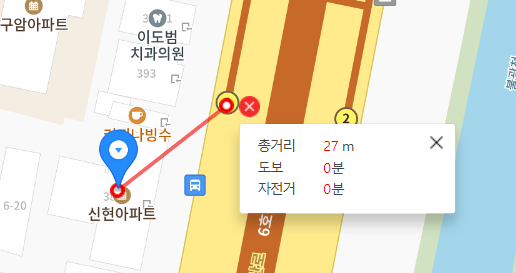

In [24]:
# 'nearest_subway_distance'가 max인 값의 위도 경도 좌표를 찾기
max_distance_row = temp_df.loc[temp_df['nearest_subway_distance'].idxmax()]
max_latitude = max_distance_row['latitude']
max_longitude = max_distance_row['longitude']

print(f"Latitude: {max_latitude}, Longitude: {max_longitude}")

Latitude: 38.1819371, Longitude: 127.105145


* Latitude: 38.1819371, Longitude: 127.105145에서 subway데이터상 최근접역(소요산역)간 거리 26286m 검증완료

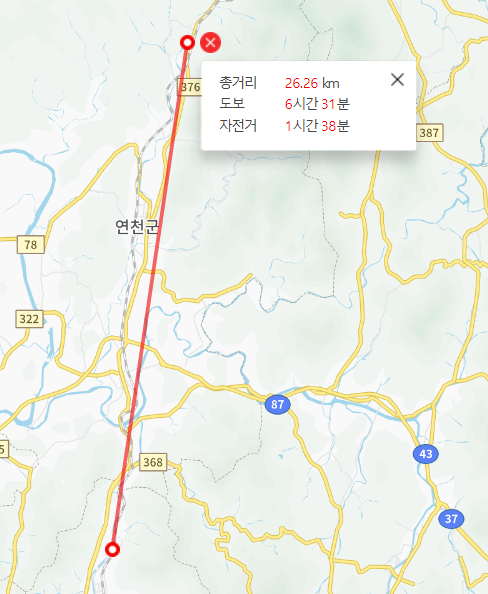

### temp_df를 df에 통합

In [38]:
# # temp_df를 etc경로에 apt_idx_representative+subwayinfo.csv로 저장
# temp_df.to_csv(os.path.join(etc_path, "apt_idx_representative+subwayinfo.csv"), index=False)

In [23]:
# temp_df와 df를 index와 _type이 일치하는 데이터끼리 매칭시켜서 temp_df의 열을 df에 추가
new_df = df.merge(temp_df[['latitude', 'longitude', 'nearest_subway_distance', 'nearest_subway_idx', 'num_subway_within_1km', 'list_subway_idx_within_1km', 'category_interchange_within_1km', 'num_subway_within_500m', 'list_subway_idx_within_500m', 'category_interchange_within_500m']],
              on=['latitude', 'longitude'], 
              how='left')

# 결과 확인
new_df.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,area_price,area_m2_price,nearest_subway_distance,nearest_subway_idx,num_subway_within_1km,list_subway_idx_within_1km,category_interchange_within_1km,num_subway_within_500m,list_subway_idx_within_500m,category_interchange_within_500m
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,...,658.914729,200.004471,717,40,1,[40],1,0,[],0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,...,891.472868,270.594284,717,40,1,[40],1,0,[],0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,...,891.472868,270.594284,717,40,1,[40],1,0,[],0
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,...,277.777778,84.260195,3897,41,0,[],0,0,[],0
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,...,99.447514,30.095302,2039,41,0,[],0,0,[],0


In [29]:
# new_df를 csv로 저장
new_df.to_csv(os.path.join(etc_path, "train+test+apt_idx+subway_features.csv"), index=False)

In [30]:
# 결측치 확인
missing_values = new_df.isnull().sum()
missing_values

index                                    0
area_m2                                  0
contract_year_month                      0
contract_day                             0
contract_type                            0
floor                                    0
built_year                               0
latitude                                 0
longitude                                0
age                                      0
deposit                             150172
_type                                    0
apt_idx                                  0
area                                     0
area_price                          150172
area_m2_price                       150172
nearest_subway_distance                  0
nearest_subway_idx                       0
num_subway_within_1km                    0
list_subway_idx_within_1km               0
category_interchange_within_1km          0
num_subway_within_500m                   0
list_subway_idx_within_500m              0
category_in

In [31]:
print(temp_df_rad)

[[0.64671978 2.21735733]
 [0.6451548  2.21754287]
 [0.64528994 2.2180432 ]
 ...
 [0.65385678 2.21033556]
 [0.65378395 2.21089568]
 [0.6538888  2.21158973]]


In [32]:
print(subway_sorted_rad)

[[0.64174887 2.21571482]
 [0.64189072 2.21749302]
 [0.64194053 2.21662486]
 ...
 [0.66171893 2.21756782]
 [0.66196635 2.21752442]
 [0.66231929 2.21763339]]
